In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd


def scanpath(fixations:pd.DataFrame, tmin:float, tmax:float, saccades:pd.DataFrame=None, samples:pd.DataFrame=None, img_path:str=None, 
             screen_res_x:int=1920, screen_res_y:int=1080):
    """
    Plots the scanpath, including fixations, saccades, and optionally an image background and gaze samples.

    Parameters
    ----------
    fixations : pd.DataFrame
        DataFrame containing fixation data with columns 'tStart', 'duration', 'xAvg', and 'yAvg'.
    tmin : float
        The minimum time for filtering the data.
    tmax : float
        The maximum time for filtering the data.
    saccades : pd.DataFrame, optional
        DataFrame containing saccade data with columns 'tStart' (default is None).
    samples : pd.DataFrame, optional
        DataFrame containing gaze sample data with columns 'tSample', 'LX', 'LY', 'RX', 'RY' (default is None).
    img_path : str, optional
        Path to an image file to be used as a background (default is None).
    screen_res_x : int, optional
        Horizontal resolution of the screen in pixels (default is 1920).
    screen_res_y : int, optional
        Vertical resolution of the screen in pixels (default is 1080).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    fixations : pd.DataFrame
        The filtered fixations DataFrame.
    saccades : pd.DataFrame
        The filtered saccades DataFrame.
    samples : pd.DataFrame
        The filtered samples DataFrame.
    """

    #----- Filter saccades, fixations and samples to defined time interval -----#
    fixations = fixations.loc[(fixations['tStart'] >= tmin) & (fixations['tStart'] <= tmax)].reset_index(drop=True)
    if type(saccades) == pd.DataFrame:
        saccades = saccades.loc[(saccades['tStart'] >= tmin) & (saccades['tStart'] <= tmax)]
    if type(samples) == pd.DataFrame:
        samples = samples.loc[(samples['tSample'] >= tmin) & (samples['tSample'] <= tmax)]


    #----- Define figure and axes -----#
    if type(samples) == pd.DataFrame:
        fig, axs = plt.subplots(nrows=2, ncols=1, height_ratios=(4, 1))
        ax_main = axs[0]
        ax_gaze = axs[1]
    else:
        fig, ax_main = plt.subplots()
    
    fig.suptitle(f'Scanpath tmin:{tmin} - tmax:{tmax}')
    ax_main.set_xlim(0, screen_res_x)
    ax_main.set_ylim(0, screen_res_y)


    #----- Plot fixations as dots if any in time interval -----#
    # Colormap: Get fixation durations for scatter circle size
    sizes = fixations['duration']
    
    # Define rainwbow cmap for fixations
    cmap = plt.cm.rainbow
    
    # Define the bins and normalize
    fix_num = fixations.index + 1
    bounds = np.linspace(1, fix_num[-1] + 1, fix_num[-1] + 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # Plot
    ax_main.scatter(fixations['xAvg'], fixations['yAvg'], c=fix_num, s=sizes, cmap=cmap, norm=norm, alpha=0.5, zorder=2)

    # Colorbar
    PCM = ax_main.get_children()[0]  # When the fixations dots for color mappable were ploted (first)
    cb = plt.colorbar(PCM, ax=ax_main, ticks=[fix_num[0] + 1/2, fix_num[int(len(fix_num)/2)]+1/2, fix_num[-1]+1/2], fraction=0.046, pad=0.04)
    cb.ax.set_yticklabels([fix_num[0], fix_num[int(len(fix_num)/2)], fix_num[-1]])
    cb.set_label('# of fixation')


    #----- Plot image if provided -----#
    if img_path != None:
        # Load search image
        img = mpimg.imread(img_path)
        
        # Get image size
        img_res_x = img.shape[1]
        img_res_y = img.shape[0]
        
        # Define box in axes to plot image
        image_box_extent = ((screen_res_x - img_res_x) / 2, img_res_x + (screen_res_x - img_res_x) / 2, (screen_res_y - img_res_y) / 2, img_res_y + (screen_res_y - img_res_y) / 2) 
        
        # Plot
        ax_main.imshow(img, extent=image_box_extent, zorder=0)

    #----- Plot scanpath and gaze if samples provided -----#
    if type(samples) == pd.DataFrame:

        # Scanpath
        ax_main.plot(samples['LX'], samples['LY'], '--', color='C0', zorder=1)
        ax_main.plot(samples['RX'], samples['RY'], '--', color='black', zorder=1)
        
        # Gaze
        ax_gaze.plot(samples['tSample'], samples['LX'], label='Left X')
        ax_gaze.plot(samples['tSample'], samples['LY'], label='Left Y')
        ax_gaze.plot(samples['tSample'], samples['RX'], label='Right X')
        ax_gaze.plot(samples['tSample'], samples['RY'], label='Right Y')

        plot_min, plot_max = ax_gaze.get_ylim()

        # Plot fixations as color span in gaze axes
        for fix_idx, fixation in fixations.iterrows():
            color = cmap(norm(fix_idx + 1))
            ax_gaze.axvspan(ymin=0, ymax=1, xmin=fixation['tStart'], xmax=fixation['tStart'] + fixation['duration'], color=color, alpha=0.4, label='fix')
        
        # Plor saccades as vlines in gaze axes
        if type(saccades) == pd.DataFrame:
            for _, saccade in saccades.iterrows():
                ax_gaze.vlines(x=saccade['tStart'], ymin=plot_min, ymax=plot_max, colors='red', linestyles='--', label='sac')

        # Legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)
        ax_gaze.set_ylabel('Gaze')
        ax_gaze.set_xlabel('Time [s]')

    return fig, fixations, saccades, samples

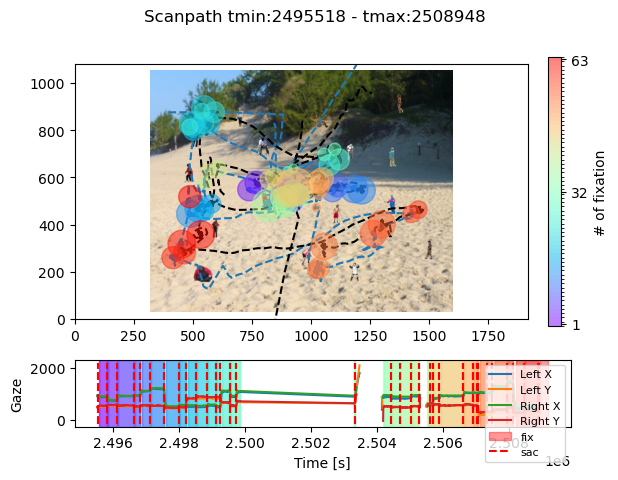

In [36]:
# ----- Example -----#
import os
import pandas as pd

# Get path to samples from parsed edf
cwd = os.getcwd()
parent_directory = os.path.abspath(os.path.join(cwd, os.pardir))
path_to_saccades = parent_directory + '/example_dataset_derivatives/sub-ab01/ses-second/sacc.hdf5'
path_to_fixations = parent_directory + '/example_dataset_derivatives/sub-ab01/ses-second/fix.hdf5'
path_to_samples = parent_directory + '/example_dataset_derivatives/sub-ab01/ses-second/samples.hdf5'

# Load samples.hdf5 file
saccades = pd.read_hdf(path_or_buf=path_to_saccades)
fixations = pd.read_hdf(path_or_buf=path_to_fixations)
samples = pd.read_hdf(path_or_buf=path_to_samples)

# Plot Scanpath
fig, fixations_t, saccades_t, samples_t = scanpath(fixations=fixations, tmin=samples['tSample'][100000], tmax=samples['tSample'][110000], saccades=saccades, samples=samples, img_path='test_img.jpg')